https://thispersondoesnotexist.com/

https://github.com/NVlabs/stylegan
https://arxiv.org/abs/1812.04948
https://github.com/NVlabs/stylegan2
https://arxiv.org/abs/1912.04958

https://machinelearningmastery.com/introduction-to-style-generative-adversarial-network-stylegan/
StyleGan | Lecture 71 (Part 1) | Applied Deep Learning
https://www.youtube.com/watch?v=hfFAUFsglLc
AI generated faces - StyleGAN explained!
https://www.youtube.com/watch?v=4LNO8nLxF4Y

In [1]:
import os

# Suppress tensorflow logging:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf

print(f'Tensorflow version: {tf.__version__}')
print(f'Tensorflow CUDA {"is" if tf.test.is_built_with_cuda() else "is not"} available.')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print('Tensorflow set GPU memory growth to True.')
    except RuntimeError as e:
        print(e)
print(f'Tensorflow {"is" if tf.executing_eagerly() else "is not"} executing eagerly.')

import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Layer, Input, Add, Dense, Flatten, Reshape, LeakyReLU, Conv2D, UpSampling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Lambda, AveragePooling2D, Activation
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as K

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython import display
import imageio
import time

dark1 = '#191b26'
dark2 = '#151722'
white1 = '#fff'
white2 = '#b3b5be'
red1 = '#cd6152'
red2 = '#cd6152'
green1 = '#67a39a'
green2 = '#253037'
blue1 = '#4a64fd'
blue2 = '#1b1f39'

mpl.rcParams['text.color'] = white2
mpl.rcParams['axes.labelcolor'] = white2
mpl.rcParams['axes.facecolor'] = dark1
mpl.rcParams['axes.edgecolor'] = white2
mpl.rcParams['figure.facecolor'] = dark2
mpl.rcParams['xtick.color'] = white2
mpl.rcParams['ytick.color'] = white2

Tensorflow version: 2.5.0
Tensorflow CUDA is available.
Tensorflow set GPU memory growth to True.
Tensorflow is executing eagerly.


In [20]:
# Define constants.

EPOCHS = 999
BATCH_SIZE = 256
IMAGE_SIZE = 28  # n in n*n image size.
NUM_CHANNELS = 1  # 1 == grayscale, 3 == RGB.
Z_LENGTH = 100  # Length of latent vector.
GRAPH_INTERVAL = 40  # How many batches to elapse before graphing progress.
PRINT_INTERVAL = 10  # How many batches to elapse before printing loss values.


def smallest_by_halving(num):
    """
    Get smallest integer by halving the input repeatedly.
    This becomes our starting generator convolution size.
    Also return number of halves performed.
    This becomes our number of generator convolution blocks.
    """
    x, count = num, 0
    while (x / 2) % 1 == 0 and (x / 2) > 2:
        x = x / 2
        count += 1
    if x >= (num / 2):
        raise ValueError(f'{num} may be unsuitable for upsampling, '
                         f'as its smallest common component is {x}, '
                         f'which is >= input of {num}.')
    return int(x), count


START_SIZE, NUM_BLOCKS = smallest_by_halving(IMAGE_SIZE)

# LINEAR_SIZE = np.prod(START_DIMS + (IMAGE_SIZE,))      # Size of Dense layer in Generator.
# LATENT_DIMS = 343           # Number of random numbers to use at Generator input.
NUM_GENERATED_SAMPLES = 8  # Number of sample fake images to generate to visualise training.

# This set of latent inputs will be used for each training graph output,
# so we can visualise progress on the same latent samples.
# def generate_latent_coordinates(batches, z_dims, const_dims):
#     return (tf.random.normal(shape=(batches, z_dims)), tf.ones(shape=(batches,) + const_dims))

# SEED = generate_latent_coordinates(NUM_GENERATED_SAMPLES, IMAGE_SIZE, START_DIMS + (IMAGE_SIZE,))
# SEED = tf.random.normal([NUM_GENERATED_SAMPLES, IMAGE_SIZE])

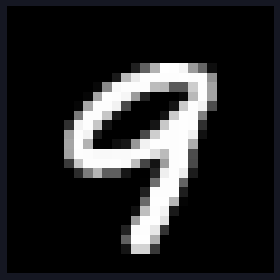

In [21]:
dataloader = tfds.load('mnist', as_supervised=True)
image_dataset = dataloader['train']
# Cast [0,255] images to [-1,1].
image_dataset = image_dataset.map(lambda image, label: Rescaling(scale=1. / 127.5, offset=-1)(image))
image_dataset = image_dataset.shuffle(BATCH_SIZE).batch(BATCH_SIZE)

batch = image_dataset.take(1)
image = list(batch.as_numpy_iterator())[0][0]

plt.axis('off')
plt.tight_layout()
plt.imshow(image, cmap='gray')
plt.show()

Set up generator and discrimator.
Display sample fake image from generator (untrained).
Display sample prediction from discriminator (untrained).

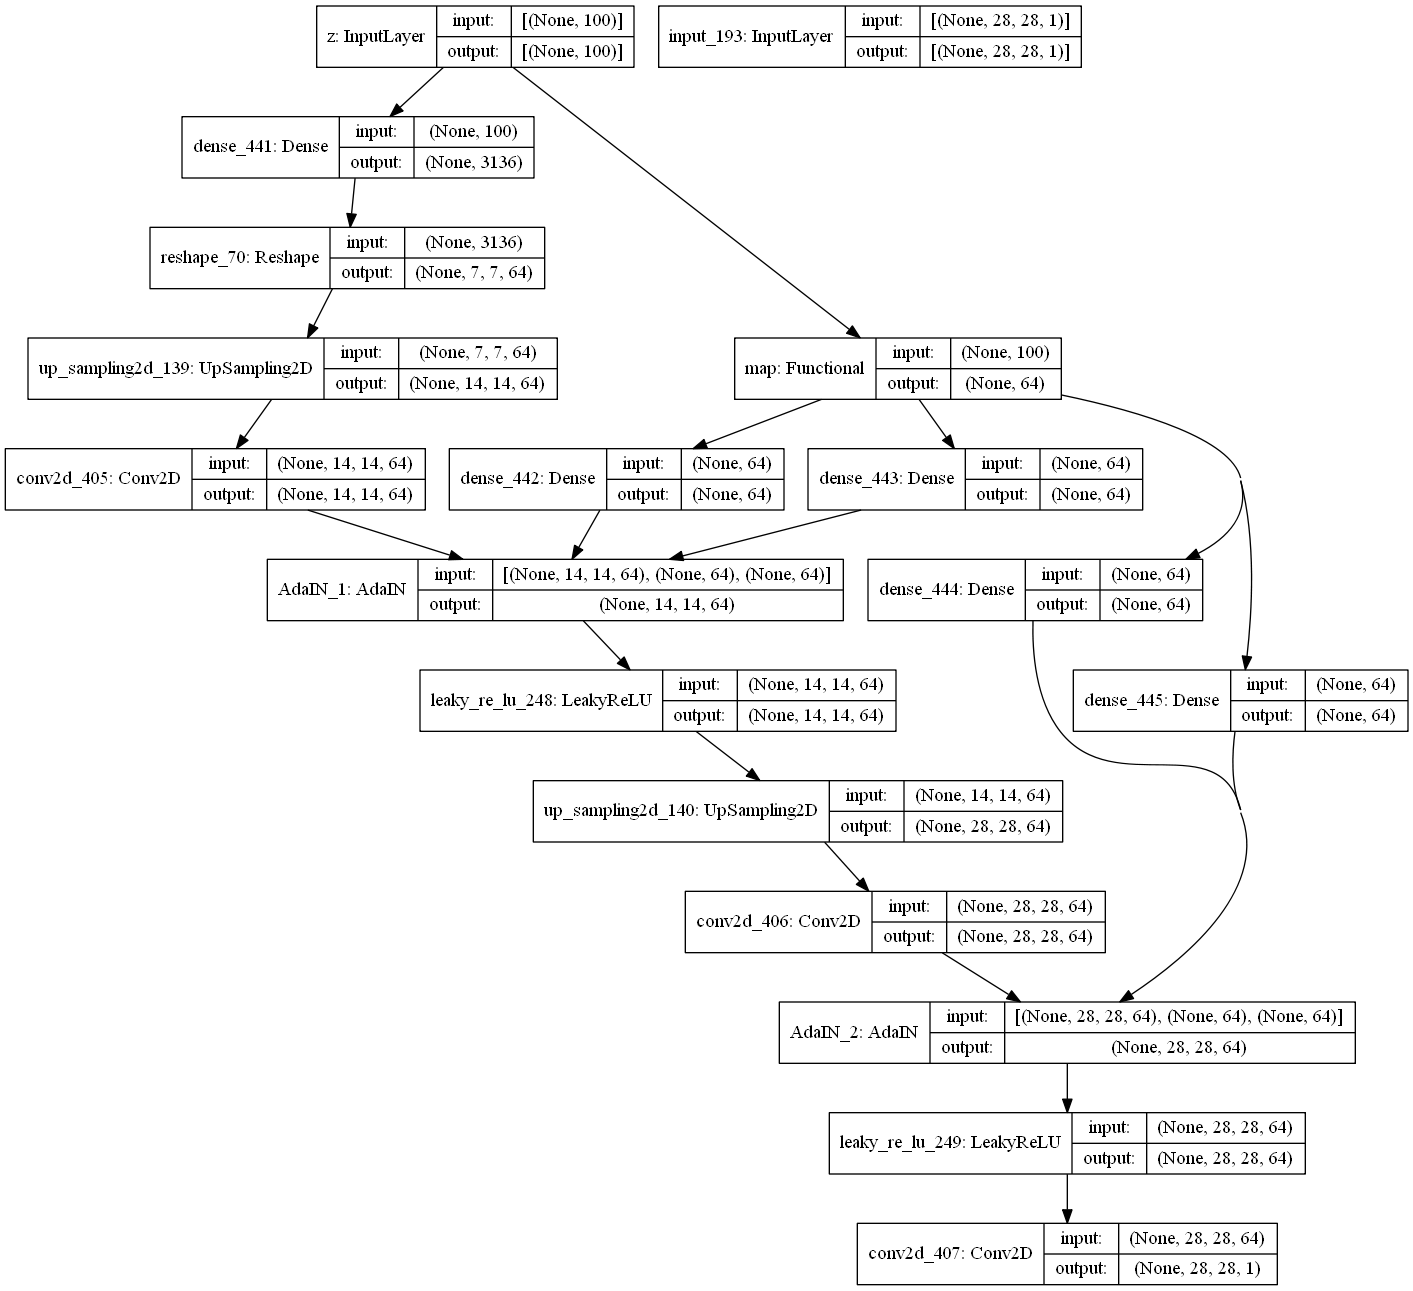

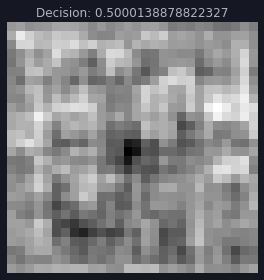

In [85]:
# Input b and g should be 1x1xC
class AdaIN(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(AdaIN, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, inputs, *args, **kwargs):
        x, scale, bias = inputs

        # Reshape (batch*len) y vectors into (batch,1,1,len) to support batched multiplication.
        scale = tf.reshape(scale, shape=(-1, 1, 1, tf.shape(scale)[-1]))
        bias = tf.reshape(bias, shape=(-1, 1, 1, tf.shape(bias)[-1]))

        mean = K.mean(x, axis=(1,2), keepdims=True)
        stddev = K.std(x, axis=(1,2), keepdims=True) + self.epsilon
        x_norm = (x - mean) / stddev

        return (x_norm * scale) + bias


def crop(x):
    height = x[1].shape[1]
    width = x[1].shape[2]
    return x[0][:, :height * 2, :width * 2, :]


#TODO: Either use_bias=False or kernel_initializer=init might be worsening results.
def make_generator():
    init = RandomNormal(mean=0., stddev=0.02)

    # Unused
    noise = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))

    # Map latent input z to style w
    z = Input(shape=(Z_LENGTH,), name='z')
    latents = Input(shape=(Z_LENGTH,))
    # TODO: Leaky relu?
    w = Dense(64, use_bias=False, activation='relu', name='w1')(latents)
    w = Dense(64, use_bias=False, activation='relu', name='w2')(w)
    w = Dense(64, use_bias=False, activation='relu', name='w3')(w)
    map = Model(inputs=latents, outputs=w, name='map')
    w = map(z)

    # Start Block
    x = Dense(START_SIZE * START_SIZE * 64, use_bias=False, activation='relu')(z)
    x = Reshape([START_SIZE, START_SIZE, 64])(x)
    # out: 7x7x64

    # Block 1
    scale = Dense(64)(w)
    bias = Dense(64)(w)
    x = UpSampling2D()(x)
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same',
               kernel_initializer=init)(x)
    x = AdaIN(input_shape=(14, 14, IMAGE_SIZE), name='AdaIN_1')([x, scale, bias])
    x = LeakyReLU(0.2)(x)
    # out: 14x14x64

    # Block 2
    scale = Dense(64)(w)
    bias = Dense(64)(w)
    x = UpSampling2D()(x)
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same',
               kernel_initializer=init)(x)
    x = AdaIN(input_shape=(28, 28, IMAGE_SIZE), name='AdaIN_2')([x, scale, bias])
    x = LeakyReLU(0.2)(x)
    # out: 28x28x64

    image = Conv2D(filters=1, kernel_size=1, strides=1, padding='same',
                   kernel_initializer=init, activation='tanh')(x)
    # out: 28x28x1, 1-channel with values between -1 and 1

    return Model(inputs=[z, noise], outputs=[image])


def make_discriminator():
    init = RandomNormal(mean=0., stddev=0.02)

    image = Input([IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS])
    # out: 28x28x1

    # Block 1
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same',
               kernel_initializer=init, activation=LeakyReLU(0.2))(image)
    x = AveragePooling2D()(x)
    # out: 14x14x32

    # Block 2
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same',
               kernel_initializer=init, activation=LeakyReLU(0.2))(x)
    x = AveragePooling2D()(x)
    # out: 7x7x32

    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same',
               kernel_initializer=init, activation=LeakyReLU(0.2))(x)
    x = Flatten()(x)

    #1-dimensional Neural Network
    classification = Dense(1, activation='sigmoid')(x)

    return Model(inputs=image, outputs=classification)


generator = make_generator()
discriminator = make_discriminator()

model_plot = tf.keras.utils.plot_model(generator, show_shapes=True, to_file='model_plot.png')
display.display(model_plot)

# Demonstrate generator and discriminator on 1 random noise sample.
generated_image = generator((tf.random.normal(mean=0., stddev=1., shape=(1, Z_LENGTH)),
                             tf.random.uniform(minval=-1., maxval=1., shape=(1, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))),
                            training=False)
decision = discriminator(generated_image, training=False)
img = generated_image.numpy()[0]
plt.title(f'Decision: {decision[0][0]}')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

gen_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
disc_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

checkpoint_dir = 'C:/Pred_Models'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=disc_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

KeyboardInterrupt: 

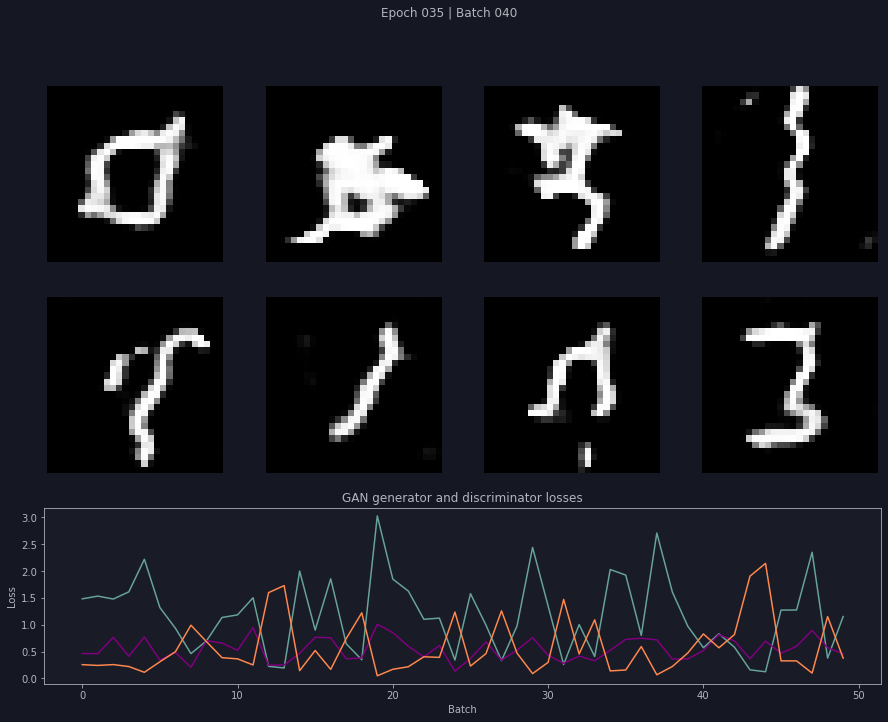

In [86]:
def plot_gan_progress(g_losses, d_real_losses, d_fake_losses, model, epoch, batch, test_input):
    """
    Plot tensorflow train and validation metrics and loss in one chart.
    :param history: Dictionary containing the accuracy and loss history.
    """
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(15, 11))
    fig.suptitle(f'Epoch {epoch:03} | Batch {batch:03}')

    for i in range(predictions.shape[0]):
        plt.subplot(3, 4, i + 1)
        plt.axis('off')
        plt.imshow(predictions[i].numpy(), cmap='gray')

    plt.subplot(3, 4, (9, 12))
    plt.title(f'GAN generator and discriminator losses')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    if len(g_losses) > 50:
        plt.plot(g_losses[len(g_losses) - 50:], c=green1, label=f'gen loss')
        plt.plot(d_real_losses[len(d_real_losses) - 50:], c='purple', label=f'disc real loss')
        plt.plot(d_fake_losses[len(d_fake_losses) - 50:], c='#ff884d', label=f'disc fake loss')
    else:
        plt.plot(g_losses, c=green1, label=f'gen loss')
        plt.plot(d_real_losses, c='purple', label=f'disc real loss')
        plt.plot(d_fake_losses, c='#ff884d', label=f'disc fake loss')
    plt.tight_layout()
    plt.legend(loc='upper left')

    # plt.savefig(f'C:/Pred_Images/preds_at_epoch{epoch:04}_batch{batch:04}.png')
    plt.show()


def disc_loss(real_output, fake_output):
    """
    How well the discriminator can distinguish real from fake images.
    :param real_output: Classifications of real images.
    :param fake_output: Classifications of fake images.
    :return: Loss on real images, loss on fake images.
    """
    # Compare predictions on real images to array of ones.
    real_loss = BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    # Compare predictions on fake images to array of zeroes.
    fake_loss = BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    return real_loss, fake_loss


def gen_loss(fake_output):
    """
    How well the generator can fool the discriminator.
    We get this loss from the discriminator, and pass it to the generator.
    :param fake_output: Discriminator classification of fake images.
    :return: Loss of discriminator on fake images, inverted.
    """
    # Compare discriminator decisions to array of ones.
    return BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)


@tf.function
def train_step(images):
    """
    Conduct forward and backward pass, updating weights of each model
    by their loss.
    :param images: Batch of images (either real or fake)
    :return: Losses, for plotting only.
    """
    # Random latent space input for generator.
    inputs = ((tf.random.normal(mean=0., stddev=1., shape=(1, Z_LENGTH)),
               tf.random.uniform(minval=-1., maxval=1., shape=(1, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))))

    # Track gradients of each model.
    # ie. Track what happened in what order during forward pass.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Forward pass.
        generated_images = generator(inputs, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        g_loss = gen_loss(fake_output)
        d_real_loss, d_fake_loss = disc_loss(real_output, fake_output)
        d_loss = d_real_loss + d_fake_loss

    # Backward pass.
    # Calculate gradient for each models trainable weights.
    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    # Update generator and discriminator weights with gradients.
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return g_loss, d_real_loss, d_fake_loss


def train(dataset, epochs):
    g_losses, d_real_losses, d_fake_losses = [], [], []
    for epoch in range(epochs):
        start = time.time()

        for i, image_batch in enumerate(dataset):
            # Start training step, tracking losses.
            g_loss, d_real_loss, d_fake_loss = train_step(image_batch)
            g_loss, d_real_loss, d_fake_loss = g_loss.numpy(), d_real_loss.numpy(), d_fake_loss.numpy()

            # Update output graph every n batches.
            if i % GRAPH_INTERVAL == 0:
                g_losses.append(g_loss)
                d_real_losses.append(d_real_loss)
                d_fake_losses.append(d_fake_loss)
                display.clear_output(wait=True)
                plot_gan_progress(g_losses, d_real_losses, d_fake_losses, generator, epoch, i, SEED)
            if i % PRINT_INTERVAL == 0:
                print(f'Epoch {epoch:04}: batch {i:04}/{len(dataset)} | g_loss: {g_loss} | '
                      f'd_fake_loss: {d_fake_loss} | d_real_loss: {d_real_loss}', end='\r')

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec\n'.format(epoch + 1, time.time() - start))


generator = make_generator()
discriminator = make_discriminator()

gen_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
disc_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

SEED = ((tf.random.normal(mean=0., stddev=1., shape=(NUM_GENERATED_SAMPLES, Z_LENGTH)),
         tf.random.uniform(minval=-1., maxval=1., shape=(NUM_GENERATED_SAMPLES, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))))

train(image_dataset, EPOCHS)

In [ ]:
# checkpoint_dir = 'C:/Pred_Models'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
#                                  discriminator_optimizer=disc_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)
#
# checkpoint.restore("C:/Pred_models/ckpt-16.index")

predictions = generator(generate_latent_coordinates(1, 100), training=False)
plt.axis('off')
plt.imshow(predictions[0].numpy(), cmap='gray')
plt.show()

predictions = generator(generate_latent_coordinates(1, 100), training=False)
plt.axis('off')
plt.imshow(predictions[0].numpy(), cmap='gray')
plt.show()